In [22]:
# Global imports
import sys, os
import re
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms
from collections import Counter, OrderedDict

%matplotlib inline 
#%matplotlib widget

import matplotlib.pyplot as plt
from matplotlib.colors import PowerNorm
from mpl_toolkits.axes_grid1 import make_axes_locatable
#plt.style.use(['dark_background'])

import numpy as np
import json
import collections
from scipy import stats
import random
import math
from datetime import datetime

# Local import
sys.path.insert(0, '../training/methods/')
# Import the neural network architectures:
from MLP import Net as MLP
from CNN import Net as CNN

sys.path.insert(0, '../training/src/')
from dataset import merger_dataset, splitDataLoader, ToTensor, Normalize

# Display the training and validation losses

In [5]:
dl_arch = 'mlp'
nb_layer = 2
dataset_size = 1106#134
optimizer_name =  "SGD" 
batch_size = 32 
learning_rate = '1e-4' 
nb_epoch = 50
metric = 'mse'
split_train = '90'

model_name = 'model_'+str(dataset_size)+'merger_'+dl_arch+'_'+str(nb_layer)+'hl_bs'+str(batch_size)+\
'_lr'+str(learning_rate)+'_'+str(nb_epoch)+'ep_opt'+str(optimizer_name)+'_split'+split_train+'_'+metric

metrics_file = '../models/'+model_name+'/metrics.json'

with open(metrics_file) as json_file:
    data_1 = json.load(json_file)

In [6]:
dl_arch = 'cnn'
nb_layer = 3
dataset_size = 1106#134
optimizer_name =  "Adam" 
batch_size = 32 
learning_rate = '1e-4' 
nb_epoch = 50
metric = 'mse'
split_train = '90'

model_name = 'model_'+str(dataset_size)+'merger_'+dl_arch+'_'+str(nb_layer)+'cv_bs'+str(batch_size)+\
'_lr'+str(learning_rate)+'_'+str(nb_epoch)+'ep_opt'+str(optimizer_name)+'_split'+split_train+'_'+metric
metrics_file = '../models/'+model_name+'/metrics.json'

with open(metrics_file) as json_file:
    data_2 = json.load(json_file)

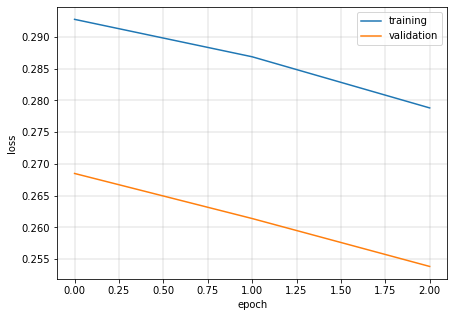

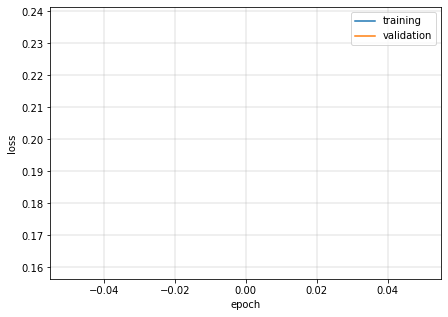

In [8]:
fig = plt.figure(1, figsize=(7,5))
plt.plot(data_1['train_loss'], label='training')
plt.plot(data_1['val_loss'], label='validation')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(loc="upper right")
plt.grid(linewidth=0.4)

fig = plt.figure(2, figsize=(7,5))
plt.plot(data_2['train_loss'], label='training')
plt.plot(data_2['val_loss'], label='validation')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(loc="upper right")
plt.grid(linewidth=0.4)

In [10]:
print(np.min(data_1['train_loss']))
print(np.min(data_1['val_loss']))
print()
print(np.min(data_2['train_loss']))
print(np.min(data_2['val_loss']))

0.2788143130403068
0.2538317696614699

0.23750590139897026
0.16029146286574278


# Load the model

In [42]:
path_to_results = '/home/mquesnel/Courses/DeepLearning/models/'
arch = "cnn"

# Load model architecture:
if arch == 'mlp':
    model = MLP(70**3, 2)
elif arch == 'cnn':
    model = CNN(1, 2)
else:
    raise ValueError("the model name specified is not valid")

model_file = path_to_results+'model_1106merger_cnn_3cv_bs32_lr1e-4_50ep_optAdam_split90_mse/model.pth'
assert os.path.isfile(model_file), "{} does not exist".format(model_file)
print("Model file name: {}\n".format(model_file))

state_dict = torch.load(model_file, map_location='cpu')

new_state_dict = OrderedDict()

model.load_state_dict(state_dict)

Model file name: /home/mquesnel/Courses/DeepLearning/models/model_1106merger_cnn_3cv_bs32_lr1e-4_50ep_optAdam_split90_mse/model.pth



<All keys matched successfully>

# Create the dataset object

We apply the same transformations to the test dataset than to the training/validation set

In [39]:
path_to_data = '/home/mquesnel/Courses/DeepLearning/datasets/density_transformed/'

# Define name of the hdf5 file containing the test data:
test_file = path_to_data+"merger_test_90cubes_no28.h5"

assert os.path.isfile(test_file), "{} does not exist".format(test_file)
print("Test dataset filename: {}".format(test_file))  

transfo = transforms.Compose([Normalize(), ToTensor()])

# Create the dataset object:xc
test_dataset = merger_dataset(path_to_file = test_file, 
                          size = dataset_size,
                          transform = transfo)

Test dataset filename: /home/mquesnel/Courses/DeepLearning/datasets/density_transformed/merger_test_90cubes_no28.h5


# Perform predictions

In [45]:
id = 0
sample = test_dataset[id]

ratio = sample['target'].numpy()
density = sample['input'].unsqueeze(0)

output =  model(density)

In [46]:
print(output)

tensor([[0.7044, 0.4621]], grad_fn=<ReluBackward0>)
